In [119]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from specutils.fitting import fit_generic_continuum
from specutils.spectra import Spectrum1D, SpectralRegion

In [120]:
from scipy.signal import medfilt

## things to do

- first continuum subtraction + removal of background noise
- find emission peaks
- find relative strengths of each peak + error
- handle double peaks with care
- correct for redshift
- find chemical abundance from a database (atomic database?)
$$
f_\text{corr} = f_\text{obs}(1+z)\\
f[i] = \text{median}(f[i-1],f[i],f[i+1])
$$

In [121]:
z = 0.017670
lambda_, intensity = np.loadtxt('ngc1275.csv', delimiter=',', unpack = True, usecols = (0,1)) # Angstrom, W / (m^2 Hz)
lambda_ /= 1+z
frequency = (299792458/lambda_)*0.01 # THz

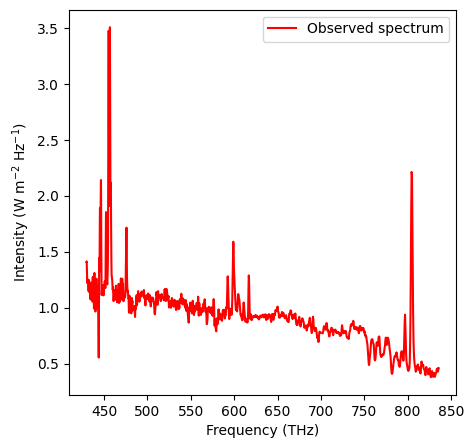

In [122]:
plt.figure(figsize=(5,5))
spectrum = Spectrum1D(flux=intensity*u.Jy, spectral_axis=lambda_*u.angstrom)
g1_fit = fit_generic_continuum(spectrum)
y_continuum_fitted = g1_fit(lambda_*u.angstrom)
flux = intensity*u.Jy-y_continuum_fitted
# flux = intensity/y_continuum_fitted
plt.plot(frequency, intensity, 'r', label='Observed spectrum')  
# plt.plot(frequency, y_continuum_fitted, 'k--', label='Continuum fit')
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()

$$
P(x) = \sum_{i=0}^{i=n}C_{i} * T_{i}(x)
$$

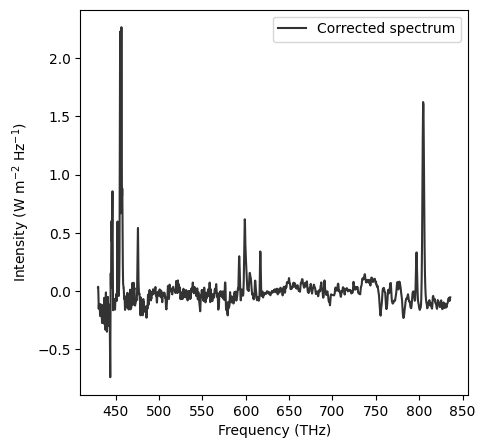

In [123]:
plt.figure(figsize=(5,5))
# flux*u.Jy+1
# plt.plot(frequency, flux*u.Jy-1, 'k')  
plt.plot(frequency, flux, 'k', alpha=0.8, label='Corrected spectrum')  
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()

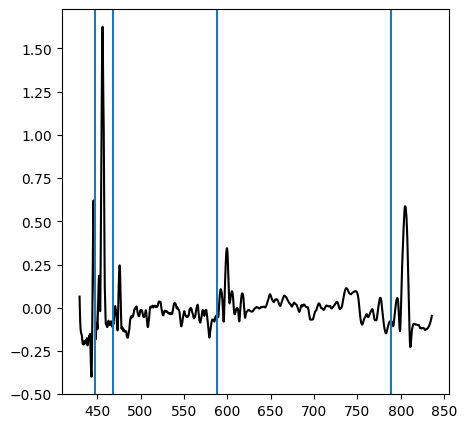

In [124]:
plt.figure(figsize=(5,5))
from scipy.signal import savgol_filter
fluxs = savgol_filter(flux, 30, 3)
spectrumf = Spectrum1D(flux=fluxs*u.Jy, spectral_axis=lambda_*u.angstrom)
plt.plot(frequency, fluxs, 'k')  
plt.axvline((299792458/3800)*0.01)
plt.axvline((299792458/5100)*0.01)
plt.axvline((299792458/6400)*0.01)
plt.axvline((299792458/6700)*0.01)

In [125]:
from specutils.fitting import find_lines_derivative
lines = find_lines_derivative(spectrumf, flux_threshold=0.25)  
ls = lines[lines['line_type'] == 'emission']
ls['line_center']

<Quantity [3722.22822722, 4999.65607712, 6569.90969568, 6725.16631128] Angstrom>

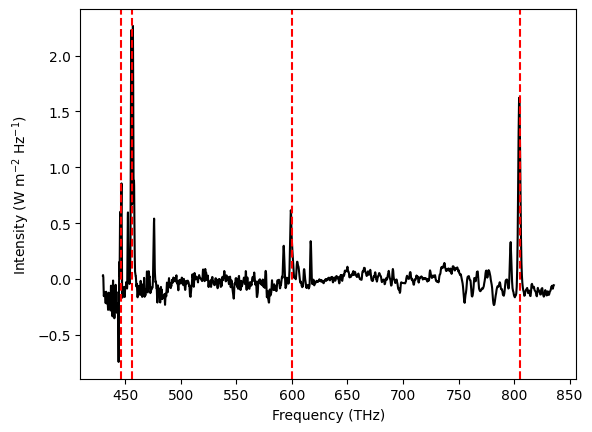

In [126]:
plt.plot(frequency, flux, 'k', alpha=1, label='Corrected spectrum')  
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.axvline((299792458/3722.2282)*0.01, color='r', linestyle='--')
plt.axvline((299792458/4999.6561)*0.01, color='r', linestyle='--')
plt.axvline((299792458/6569.9097)*0.01, color='r', linestyle='--')
plt.axvline((299792458/6725.1663)*0.01, color='r', linestyle='--')
# plt.legend()

In [127]:
flux

<Quantity [-0.05524473, -0.06576258, -0.08647865, ...,  0.03125408,
            0.03595379,  0.03125209] Jy>

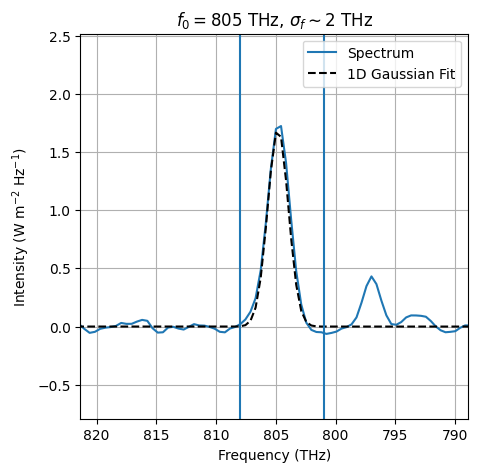

In [135]:
from specutils.fitting import fit_lines
from astropy.modeling import models
g_init = models.Gaussian1D(amplitude=1.7*u.Jy, mean=3725*u.Angstrom, stddev=4.*u.Angstrom)
spectrum =  Spectrum1D(flux=savgol_filter(flux, 30, 5)*u.Jy, spectral_axis=lambda_*u.angstrom)
g_fit = fit_lines(spectrum, g_init, window=(6200*u.Angstrom, 6800*u.Angstrom))
y_fit = g_fit(lambda_*u.Angstrom)
plt.figure(figsize=(5,5))

plt.plot(frequency, flux/u.Jy+0.1, label='Spectrum')
plt.plot(frequency, y_fit, 'k--', label='1D Gaussian Fit')
plt.title('$f_{0}=805$ THz, $\sigma_f \sim 2$ THz')
plt.grid(True)
plt.xlim((299792458/3650)*0.01,(299792458/3800)*0.01)
# plt.ylim(-0.5,2)
plt.xlabel('Frequency (THz)')
plt.ylabel('Intensity (W m$^{-2}$ Hz$^{-1}$)')
plt.legend()
plt.axvline(808)
plt.axvline(801)

$$
\text{Strength}_{f} = \sqrt{\frac{\pi}{\sigma_f}} 
$$

In [129]:
(299792458/4)*0.01

749481.145

In [130]:
u.Angstrom

Unit("Angstrom")

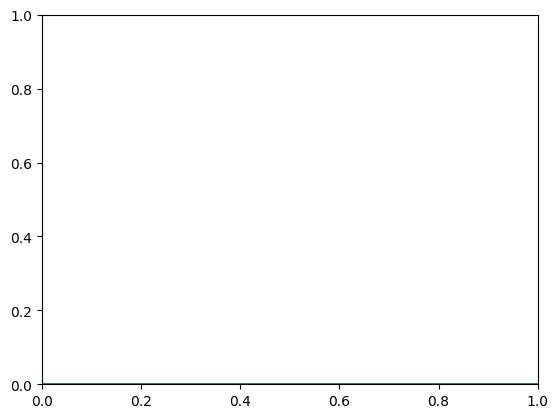

In [131]:
# a, b = 20, 130
# plt.plot(lambda_[a:b], flux[a:b]) 
# a, b = 1400, 1630
# plt.plot(lambda_[a:b], flux[a:b]) 
plt.axhline(0)

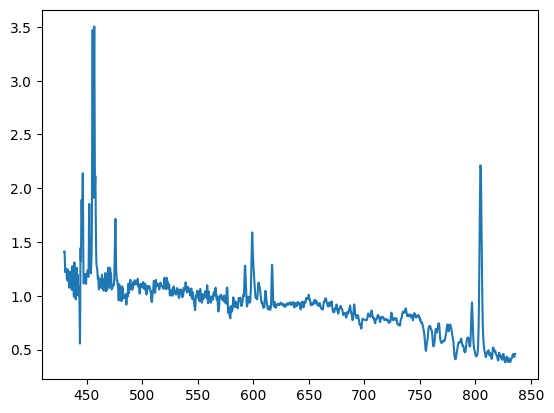

In [132]:
plt.plot(frequency, intensity)

# Step I: Continuum Subtraction